In [1]:
# Importing necessary packages for python
import pandas as pd
import numpy as np
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.linear_model import LogisticRegression
import warnings
import matplotlib.pyplot as plt
import plotly.tools as tls
import datetime as dt
import time as tm
import calendar as cal

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', DeprecationWarning)
pd.set_option('mode.chained_assignment', None)

%matplotlib inline

In [2]:
# Importing data from Lab#1 and exploring the data, the csv file is the result dataset from Lab1
path = "../Data/" # Generic path
incident = pd.read_csv(path + 'LAB1_completed_Dataset_clean.csv', low_memory= False)

In [3]:
def get_unixtime(time): 
    return (time.astype(np.int64)/1e6).astype(np.int64)

In [4]:
%%time

# Exploying the dataset
incident['Response_time'] = incident['Response_time'].fillna(incident['Response_time'].mean()).astype(np.int)
incident = incident[incident['Call_Received_Hour'].isnull()==False]
incident_NullCols = incident.isnull().sum()
incident_NullCols = incident_NullCols[incident_NullCols > 0]

# Dropna on Datetime columns
incident.dropna(subset=['Call_Cleared_Date_Time', 'Call_Dispatch_Date_Time', 'Call_Received_Date_Time'], inplace=True)

# Print out the data properties
print(incident.shape)
print('Number of null columns and their counts')
print(incident_NullCols)

# Convert Date Time columns from Char to Datetime Format
# Call_Cleared_Date_Time
# Call_Dispatch_Date_Time
# Call_Received_Date_Time    

incident['Call_Cleared_Date_Time'] = pd.to_datetime(incident['Call_Cleared_Date_Time'])
incident['Call_Dispatch_Date_Time'] = pd.to_datetime(incident['Call_Dispatch_Date_Time'])
incident['Call_Received_Date_Time'] = pd.to_datetime(incident['Call_Received_Date_Time'])

# Convert Date Time columns from Datetime to EPOCH Format
incident['Call_Cleared_Date_Time_epoch']=get_unixtime(incident['Call_Cleared_Date_Time'])
incident['Call_Dispatch_Date_Time_epoch']=get_unixtime(incident['Call_Dispatch_Date_Time'])
incident['Call_Received_Date_Time_epoch']=get_unixtime(incident['Call_Received_Date_Time'])

incident.info()

(253905, 45)
Number of null columns and their counts
Type_Location                4856
Reporting_Area                155
Beat                           70
Sector                         70
Call_Cleared_Date_Time        165
Call_Dispatch_Date_Time        21
Offense_Status                557
Victim_Condition           233793
Family_Offense                 32
Weapon_Used                 28804
UCR_Offense_Name            14475
UCR_Code                    14475
X_Coordinate                21095
Y_Coordinate                21095
State                         608
Call_Cleared                  165
Call_Dispatch                  21
Latitude                     9755
Longitude                    9755
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 253905 entries, 0 to 255153
Data columns (total 48 columns):
Unnamed: 0                       253905 non-null int64
Year_of_Incident                 253905 non-null int64
Service_Number_ID                253905 non-null object
Watch      

In [5]:
incident['Call_Dispatch_Date_Time_epoch'].head()

0    1469159553000
1    1446749511000
2    1490295085000
3    1532792901000
4    1532158636000
Name: Call_Dispatch_Date_Time_epoch, dtype: int64

In [6]:
# Further cleanup the dataset
incident = incident[incident['Watch']!=0]
incident = incident[(incident['Victim_Age']>=0) & (incident['Victim_Age']<=90)]
incident = incident[incident['Victim_Race']!="Unknown"]
incident = incident[incident['Victim_Type']!="Unknown"]
incident= incident[incident.Number_of_offense != "RP"]

incident = incident[incident['Victim_Gender']!="U"]

In [7]:
# Further data clean up on the feature variables

incident.loc[:,'UCR_Offense_Name'] = incident['UCR_Offense_Name'].fillna("MISSING")

# Setup the UCR Offense Name Groups
THEFT_FRAUD     = dict.fromkeys(['THEFT/BMV', 'THEFT ORG RETAIL', 'BURGLARY-RESIDENCE', 'OTHER THEFTS',
                                 'ROBBERY-INDIVIDUAL','THEFT/SHOPLIFT', 'BURGLARY-BUSINESS', 'FORGE & COUNTERFEIT', 
                                 'FRAUD', 'EMBEZZLEMENT','ROBBERY-BUSINESS','THEFT ORG RETAIL'],"THEFT_FRAUD" ) 
MVA_TRAFFIC      =dict.fromkeys(['ACCIDENT MV', 'MOTOR VEHICLE ACCIDENT', 'UUMV', 'TRAFFIC VIOLATION',
                                 'TRAFFIC FATALITY'],"MVA_TRAFFIC" )        
WEAPONS_FIREARMS =dict.fromkeys(['WEAPONS', 'ARSON', 'INJURED FIREARM'], "WEAPONS_FIREARMS")         
ASSUALT          = dict.fromkeys(['ASSAULT','VANDALISM & CRIM MISCHIEF', 'AGG ASSAULT - NFV', 'OFFENSE AGAINST CHILD',
                                  'AGG ASSAULT - FV'], "ASSUALT")
OTHERS_THREATS   = dict.fromkeys(['FOUND', 'OTHERS', 'LOST', 'CRIMINAL TRESPASS', 'DISORDERLY CONDUCT', 
                                  'ANIMAL BITE','INJURED HOME','INJURED PUBLIC', 'TERRORISTIC THREAT', 
                                  'EVADING', 'INJURED OCCUPA', 'ORANIZED CRIME', 'KIDNAPPING', 
                                  'RESIST ARREST','FAIL TO ID', 'HUMAN TRAFFICKING', 'MISSING'], "OTHERS_THREATS")
INTOXICATION     = dict.fromkeys(['DRUNK & DISORDERLY', 'DWI', 'NARCOTICS & DRUGS', 'LIQUOR OFFENSE', 
                                  'INTOXICATION MANSLAUGHTER'],"INTOXICATION")
MURDER_DEATH     = dict.fromkeys(['SUDDEN DEATH&FOUND BODIES','MURDER'], "MURDER_DEATH")
                    
# Regroup the UCR_Offense_Name
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(THEFT_FRAUD)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(MVA_TRAFFIC)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(WEAPONS_FIREARMS)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(ASSUALT)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(OTHERS_THREATS)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(INTOXICATION)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(MURDER_DEATH)

In [8]:
# Change norminal attributes to numeric
incident.loc[:,'IsMale'] = incident.Victim_Gender=='M' 
incident.IsMale = incident.IsMale.astype(np.int)
incident.loc[:,'Social_crime_score'] = incident['Hate_Crime']+incident['Gang_Related_Offense']+incident['Drug_Related']
incident.loc[:,'Victim_Age'] = incident['Victim_Age'].astype(np.int)
incident.loc[:,'Number_of_offense']= incident.Number_of_offense.astype(np.int)
# coding
incident['UCR_Offense_Name'] = pd.Categorical(incident['UCR_Offense_Name']).codes
incident['Day1_of_the_Week'] = pd.Categorical(incident['Day1_of_the_Week']).codes
incident['Division'] = pd.Categorical(incident['Division']).codes
incident['Victim_Type'] = pd.Categorical(incident['Victim_Type']).codes
incident['Victim_Race'] = pd.Categorical(incident['Victim_Race']).codes

In [9]:
incident.loc[:,'Response_time'] = incident['Response_time'].fillna(incident['Response_time'].mean()).astype(np.int)
incident.loc[:,'Responsetime_cat'] = pd.cut(incident.Response_time,[0, 10, 999],2,labels=[0,1])
incident= incident[incident['Responsetime_cat']>=0]

In [10]:
incident.columns

Index(['Unnamed: 0', 'Year_of_Incident', 'Service_Number_ID', 'Watch',
       'Type_of_Incident', 'Type_Location', 'Reporting_Area', 'Beat',
       'Division', 'Sector', 'Council_District', 'Day1_of_the_Week',
       'Call_Received_Date_Time', 'Call_Cleared_Date_Time',
       'Call_Dispatch_Date_Time', 'Person_Involvement_Type', 'Victim_Type',
       'Victim_Race', 'Victim_Gender', 'Victim_Age', 'Offense_Status',
       'Victim_Condition', 'Hate_Crime', 'Family_Offense', 'Weapon_Used',
       'Gang_Related_Offense', 'Drug_Related', 'UCR_Offense_Name', 'RMS_Code',
       'UCR_Code', 'X_Coordinate', 'Y_Coordinate', 'Zip_Code', 'City', 'State',
       'Location1', 'Call_Received', 'Call_Cleared', 'Call_Dispatch',
       'Number_of_offense', 'Response_time', 'Latitude', 'Longitude',
       'Arrest_status', 'Call_Received_Hour', 'Call_Cleared_Date_Time_epoch',
       'Call_Dispatch_Date_Time_epoch', 'Call_Received_Date_Time_epoch',
       'IsMale', 'Social_crime_score', 'Responsetime_cat'],

In [11]:
incident = incident.drop(['Unnamed: 0', 'Year_of_Incident', 'Service_Number_ID', 'Type_of_Incident','Type_Location', 
                          'Reporting_Area', 'Beat', 'Sector','Council_District', 'Victim_Race', 'Day1_of_the_Week',
                          'Person_Involvement_Type', 'Zip_Code', 'Call_Received_Date_Time', 'Call_Cleared_Date_Time', 
                          'Call_Dispatch_Date_Time', 'Victim_Gender', 'Offense_Status', 'Victim_Condition','Family_Offense', 
                          'Weapon_Used', 'RMS_Code', 'UCR_Code','X_Coordinate', 'Y_Coordinate', 'City', 'State',
                          'Location1', 'Call_Received', 'Call_Cleared', 'Call_Dispatch','Latitude', 'Longitude'],axis=1)

In [12]:
incident.sample(2)

,Watch,Division,Victim_Type,Victim_Age,Hate_Crime,Gang_Related_Offense,Drug_Related,UCR_Offense_Name,Number_of_offense,Response_time,Arrest_status,Call_Received_Hour,Call_Cleared_Date_Time_epoch,Call_Dispatch_Date_Time_epoch,Call_Received_Date_Time_epoch,IsMale,Social_crime_score,Responsetime_cat
35475,1,5,2,60,0,0,0,0,1,12,0,16.0,1483551535000,1483549688000,1483548961000,1,0,1
28748,1,2,2,35,0,0,0,3,1,72,0,7.0,1512559572000,1512550870000,1512546550000,0,0,1


Class 0: 180741
Class 1: 19887
Proportion: 9.09 : 1


<Figure size 576x360 with 0 Axes>

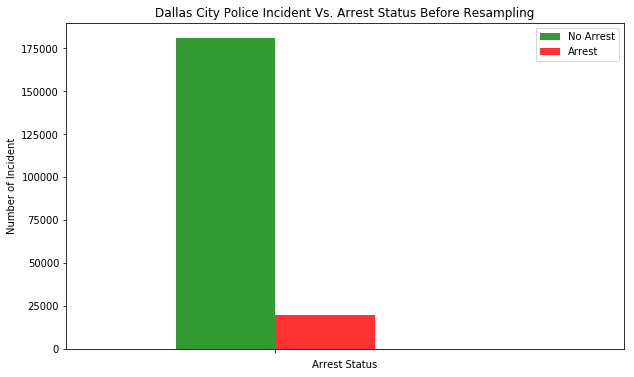

In [13]:
# Explore response variable distribution
plt.figure(figsize=(8,5))
target_count = incident.Arrest_status.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

# Draw bar plot

# data to plot
n_groups = 1
NoArrest=incident.Arrest_status.value_counts()[0]
Arrest=incident.Arrest_status.value_counts()[1]
 
# create plot
index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.8
plt.figure(figsize=(10,6))
plt.bar(index, NoArrest, bar_width,
                 alpha=opacity,
                 color='g',
                 label='No Arrest')
 
plt.bar(index + bar_width, Arrest, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Arrest')
 
plt.xlabel('Arrest Status')
plt.ylabel('Number of Incident')
plt.title('Dallas City Police Incident Vs. Arrest Status Before Resampling')
plt.xlim(-0.8, 2)
plt.xticks(index + bar_width/2, (''))
plt.legend()
 
plt.show()

In [14]:
# Import resample package
from sklearn.utils import resample

# Downsampling
df_majority = incident[incident.Arrest_status==0]
df_minority = incident[incident.Arrest_status==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,   # sample without replacement
                                 n_samples=19887, # to match minority class
                                 random_state=0)  # Seeding
 
# Combine minority class with downsampled majority class
df_incident_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_incident_downsampled.Arrest_status.value_counts()

1    19887
0    19887
Name: Arrest_status, dtype: int64

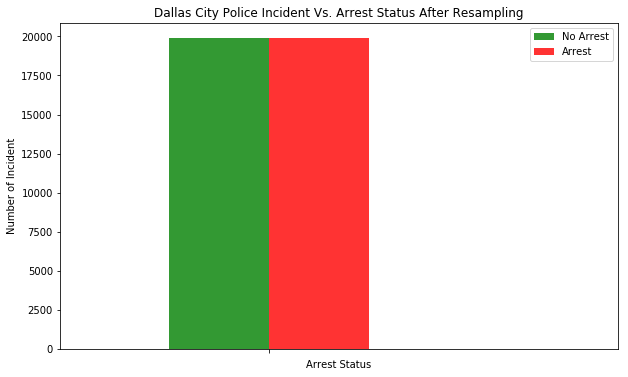

In [15]:
n_groups = 1
NoArrest=df_incident_downsampled.Arrest_status.value_counts()[0]
Arrest=df_incident_downsampled.Arrest_status.value_counts()[1]
 
# create plot
#ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.8
plt.figure(figsize=(10,6))
plt.bar(index, NoArrest, bar_width,
                 alpha=opacity,
                 color='g',
                 label='No Arrest')
 
plt.bar(index + bar_width, Arrest, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Arrest')
 
plt.xlabel('Arrest Status')
plt.ylabel('Number of Incident')
plt.title('Dallas City Police Incident Vs. Arrest Status After Resampling')
plt.xlim(-0.8, 2)
plt.xticks(index + bar_width/2, (''))
plt.legend()
 
#plt.tight_layout()
plt.show()

In [16]:
#Create correlation matrix of Incident Dataset
CorrMat = incident.corr()

# Highest Correlation Pairs
corrPairs = CorrMat.unstack().sort_values(kind="quicksort", ascending=False)
#- REMOVE DUPLICATES
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',10):
    print(corrPairs)

Call_Dispatch_Date_Time_epoch  Call_Received_Date_Time_epoch    1.000000
Call_Cleared_Date_Time_epoch   Call_Dispatch_Date_Time_epoch    0.999969
Call_Received_Date_Time_epoch  Call_Cleared_Date_Time_epoch     0.999969
Drug_Related                   Social_crime_score               0.857580
Call_Received_Hour             Watch                            0.679531
                                                                  ...   
Response_time                  Number_of_offense               -0.050339
UCR_Offense_Name               Division                        -0.056018
                               Watch                           -0.081668
Arrest_status                  Response_time                   -0.098629
UCR_Offense_Name               Arrest_status                   -0.199062
Length: 136, dtype: float64


In [17]:
#Drop highly correlated, insignificant and high VIF columns.
incident = incident.drop(['Drug_Related','Watch','Gang_Related_Offense','Hate_Crime', 'Call_Received_Date_Time_epoch', 'Call_Cleared_Date_Time_epoch'], axis=1)

#Create correlation matrix of Incident Dataset
CorrMat = incident.corr()

# Highest Correlation Pairs
corrPairs = CorrMat.unstack().sort_values(kind="quicksort", ascending=False)
#- REMOVE DUPLICATES
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',10):
    print(corrPairs)

Call_Received_Hour  Response_time         0.081913
Arrest_status       Number_of_offense     0.068091
UCR_Offense_Name    Response_time         0.065039
IsMale              Victim_Age            0.060306
UCR_Offense_Name    IsMale                0.055501
                                            ...   
Response_time       Social_crime_score   -0.049175
                    Number_of_offense    -0.050339
UCR_Offense_Name    Division             -0.056018
Arrest_status       Response_time        -0.098629
                    UCR_Offense_Name     -0.199062
Length: 55, dtype: float64


In [18]:
incident.columns

Index(['Division', 'Victim_Type', 'Victim_Age', 'UCR_Offense_Name',
       'Number_of_offense', 'Response_time', 'Arrest_status',
       'Call_Received_Hour', 'Call_Dispatch_Date_Time_epoch', 'IsMale',
       'Social_crime_score', 'Responsetime_cat'],
      dtype='object')

In [19]:
#Create correlation matrix of Downsampled Dataset
CorrMat = df_incident_downsampled.corr()

# Highest Correlation Pairs
corrPairs = CorrMat.unstack().sort_values(kind="quicksort", ascending=False)
#- REMOVE DUPLICATES
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',10):
    print(corrPairs)

Call_Dispatch_Date_Time_epoch  Call_Received_Date_Time_epoch    1.000000
Call_Received_Date_Time_epoch  Call_Cleared_Date_Time_epoch     0.999921
Call_Cleared_Date_Time_epoch   Call_Dispatch_Date_Time_epoch    0.999921
Social_crime_score             Drug_Related                     0.853628
Watch                          Call_Received_Hour               0.736428
                                                                  ...   
Response_time                  Social_crime_score              -0.057214
Number_of_offense              Response_time                   -0.060404
UCR_Offense_Name               Watch                           -0.107780
Arrest_status                  Response_time                   -0.181576
                               UCR_Offense_Name                -0.312329
Length: 136, dtype: float64


In [20]:
#Drop highly correlated, insignificant and high VIF columns.
df_incident_downsampled = df_incident_downsampled.drop(['Drug_Related','Watch','Gang_Related_Offense','Hate_Crime', 'Call_Received_Date_Time_epoch', 'Call_Cleared_Date_Time_epoch'], axis=1)

#Create correlation matrix
CorrMat = df_incident_downsampled.corr()

# Highest Correlation Pairs
corrPairs = CorrMat.unstack().sort_values(kind="quicksort", ascending=False)
#- REMOVE DUPLICATES
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',10):
    print(corrPairs)

Social_crime_score  Number_of_offense     0.099867
UCR_Offense_Name    Response_time         0.092831
Number_of_offense   Arrest_status         0.087840
Response_time       Call_Received_Hour    0.086713
IsMale              Victim_Age            0.080291
                                            ...   
Division            UCR_Offense_Name     -0.053050
Response_time       Social_crime_score   -0.057214
Number_of_offense   Response_time        -0.060404
Response_time       Arrest_status        -0.181576
UCR_Offense_Name    Arrest_status        -0.312329
Length: 55, dtype: float64


In [21]:
# Y Response variable dataframe
inci_Y = incident['Arrest_status']

# Features with no predictive features with respect to resposne variable
inci_X = incident.drop(['Arrest_status', 'Responsetime_cat'],axis=1)

In [22]:
# Y Response variable dataframe
inci_downsampled_Y = df_incident_downsampled['Arrest_status']

# Features with no predictive features with respect to resposne variable
inci_downsampled_X = df_incident_downsampled.drop(['Arrest_status', 'Responsetime_cat'],axis=1)

In [23]:
inci_Y.count()

200628

In [24]:
inci_downsampled_Y.count()

39774

In [25]:
from sklearn.preprocessing import StandardScaler

#Scale data
scaler = StandardScaler()
# inci_X = scaler.fit_transform(inci_X)

#Save as data frames
inci_X = pd.DataFrame(scaler.fit_transform(inci_X), columns=inci_X.columns)
inci_X.sample(2)

,Division,Victim_Type,Victim_Age,UCR_Offense_Name,Number_of_offense,Response_time,Call_Received_Hour,Call_Dispatch_Date_Time_epoch,IsMale,Social_crime_score
175050,-1.087969,0.001072,-0.411837,0.901512,-0.210244,-0.863865,0.051694,1.438425,0.938008,-0.111968
36103,0.429161,0.001072,1.167779,-1.498071,-0.210244,-0.566638,0.848987,0.859717,0.938008,-0.111968


In [26]:
from sklearn.preprocessing import StandardScaler

#Scale data
scaler = StandardScaler()
# inci_X = scaler.fit_transform(inci_X)

#Save as data frames
inci_downsampled_X = pd.DataFrame(scaler.fit_transform(inci_downsampled_X), columns=inci_downsampled_X.columns)
inci_downsampled_X.sample(2)

,Division,Victim_Type,Victim_Age,UCR_Offense_Name,Number_of_offense,Response_time,Call_Received_Hour,Call_Dispatch_Date_Time_epoch,IsMale,Social_crime_score
5281,1.408651,0.006954,-0.022703,1.094809,-0.229267,0.121476,-0.587275,-1.375560,0.935925,-0.142081
7617,-1.622002,0.006954,-0.232768,-1.153785,-0.229267,-0.424755,-0.124967,0.154722,-1.068462,-0.142081


In [27]:
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_score, precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier

In [28]:
%%time

cv = StratifiedShuffleSplit(inci_Y, n_iter = 1, test_size = 0.2, random_state=0)
cv_downsampled = StratifiedShuffleSplit(inci_downsampled_Y, n_iter = 1, test_size = 0.2, random_state=0)

Wall time: 13 ms


In [29]:
%%time

for train_index, test_index in cv:
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = inci_X.iloc[train_index,], inci_X.iloc[test_index,]
    y_train, y_test = inci_Y.iloc[train_index,], inci_Y.iloc[test_index,]

TRAIN: [ 75983   7920 152806 ... 198918  17960  76103] TEST: [163436  22112 159950 ...  77437  46503 104747]
Wall time: 70.8 ms


In [30]:
%%time

for train_index, test_index in cv_downsampled:
    print("TRAIN:", train_index, "TEST:", test_index)
    X_downsampled_train, X_downsampled_test = inci_downsampled_X.iloc[train_index,], inci_downsampled_X.iloc[test_index,]
    y_downsampled_train, y_downsampled_test = inci_downsampled_Y.iloc[train_index,], inci_downsampled_Y.iloc[test_index,]

TRAIN: [30407 12457 23786 ... 15098 35889  3858] TEST: [36640 18037 21281 ... 34684 16627 24757]
Wall time: 16 ms


In [31]:
%%time

error_rate = []
acc_score = []
pres_score = []

# Will take some time
for K in np.arange(1, 40, 1):
    print("Iteration:: ",K)
    knn = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean')
    knn.fit(X_train,y_train)
    yhat = knn.predict(X_test)
    
    error_rate.append(np.mean(yhat != y_test))
    acc = accuracy_score(y_test, yhat)
    pres = precision_score(y_test, yhat)
    acc_score.append(acc)
    pres_score.append(pres)
    print('Classification Report')
    print(classification_report(y_test, yhat))
    print('Confusion Matrix')
    print(confusion_matrix(y_test, yhat))
    print('Accuracy of classifier with %d neighbors is: %.2f'%(K,acc))
    print('Precision Score of classifier with %d neighbors is: %.2f'%(K,pres))

Iteration::  1
Classification Report
             precision    recall  f1-score   support

          0       0.91      0.91      0.91     36149
          1       0.17      0.16      0.17      3977

avg / total       0.83      0.84      0.84     40126

Confusion Matrix
[[32945  3204]
 [ 3328   649]]
Accuracy of classifier with 1 neighbors is: 0.84
Precision Score of classifier with 1 neighbors is: 0.17
Iteration::  2
Classification Report
             precision    recall  f1-score   support

          0       0.90      0.99      0.94     36149
          1       0.22      0.03      0.06      3977

avg / total       0.84      0.89      0.86     40126

Confusion Matrix
[[35671   478]
 [ 3841   136]]
Accuracy of classifier with 2 neighbors is: 0.89
Precision Score of classifier with 2 neighbors is: 0.22
Iteration::  3
Classification Report
             precision    recall  f1-score   support

          0       0.91      0.96      0.93     36149
          1       0.21      0.09      0.13    

Classification Report
             precision    recall  f1-score   support

          0       0.90      1.00      0.95     36149
          1       0.26      0.00      0.01      3977

avg / total       0.84      0.90      0.85     40126

Confusion Matrix
[[36110    39]
 [ 3963    14]]
Accuracy of classifier with 22 neighbors is: 0.90
Precision Score of classifier with 22 neighbors is: 0.26
Iteration::  23
Classification Report
             precision    recall  f1-score   support

          0       0.90      1.00      0.95     36149
          1       0.31      0.01      0.01      3977

avg / total       0.84      0.90      0.85     40126

Confusion Matrix
[[36093    56]
 [ 3952    25]]
Accuracy of classifier with 23 neighbors is: 0.90
Precision Score of classifier with 23 neighbors is: 0.31
Iteration::  24
Classification Report
             precision    recall  f1-score   support

          0       0.90      1.00      0.95     36149
          1       0.28      0.00      0.01      3977

a

Wall time: 44.9 ms


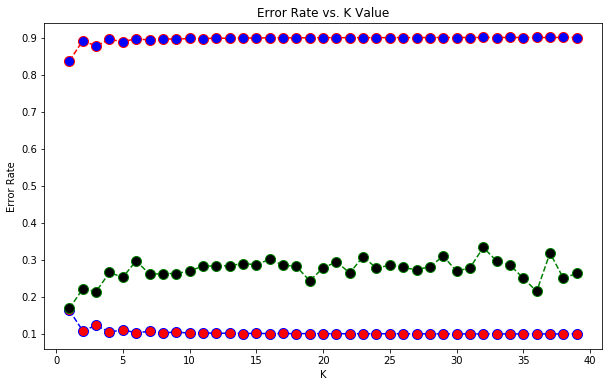

In [32]:
%%time

plt.figure(figsize=(10,6))
plt.plot(np.arange(1, 40, 1),error_rate,color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.plot(np.arange(1, 40, 1),acc_score,color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
plt.plot(np.arange(1, 40, 1),pres_score,color='green', linestyle='dashed', marker='o', markerfacecolor='black', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [45]:
%%time

K=32

knn = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean')
knn.fit(X_train,y_train)
yhat = knn.predict(X_test)

acc = accuracy_score(y_test, yhat)
pres = precision_score(y_test, yhat)
print('Classification Report')
print(classification_report(y_test, yhat))
print('Confusion Matrix')
print(confusion_matrix(y_test, yhat))
print('Accuracy of classifier with %d neighbors is: %.2f'%(K,acc))
print('Precision Score of classifier with %d neighbors is: %.2f'%(K,pres))

Classification Report
             precision    recall  f1-score   support

          0       0.90      1.00      0.95     36149
          1       0.33      0.00      0.00      3977

avg / total       0.84      0.90      0.85     40126

Confusion Matrix
[[36139    10]
 [ 3972     5]]
Accuracy of classifier with 32 neighbors is: 0.90
Precision Score of classifier with 32 neighbors is: 0.33
Wall time: 1min 56s


In [34]:
from sklearn.neighbors.nearest_centroid import NearestCentroid

In [35]:
%%time

for d in ['l1', 'l2', 'cosine', 'euclidean']:
    clf = NearestCentroid(metric=d)
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    acc = accuracy_score(y_test, yhat)
    pres = precision_score(y_test, yhat)
    print('Classification Report')
    print(classification_report(y_test, yhat))
    print('Confusion Matrix')
    print(confusion_matrix(y_test, yhat))
    print('Accuracy of classifier with %s metric is: %.2f'%(d,acc))
    print('Precision Score of classifier with %s metric is: %.2f'%(d,pres))

Classification Report
             precision    recall  f1-score   support

          0       0.94      0.79      0.86     36149
          1       0.21      0.52      0.30      3977

avg / total       0.86      0.76      0.80     40126

Confusion Matrix
[[28477  7672]
 [ 1919  2058]]
Accuracy of classifier with l1 metric is: 0.76
Precision Score of classifier with l1 metric is: 0.21
Classification Report
             precision    recall  f1-score   support

          0       0.94      0.71      0.81     36149
          1       0.19      0.60      0.28      3977

avg / total       0.87      0.70      0.76     40126

Confusion Matrix
[[25622 10527]
 [ 1571  2406]]
Accuracy of classifier with l2 metric is: 0.70
Precision Score of classifier with l2 metric is: 0.19
Classification Report
             precision    recall  f1-score   support

          0       0.94      0.62      0.75     36149
          1       0.16      0.67      0.26      3977

avg / total       0.87      0.62      0.70   

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
rfc = RandomForestClassifier(n_estimators=200)

In [38]:
rfc.fit(X_train, y_train)

yhat_downsampled = rfc.predict(X_test)

acc = accuracy_score(y_test, yhat)
pres = precision_score(y_test, yhat)
print('Classification Report')
print(classification_report(y_test, yhat))
print('Confusion Matrix')
print(confusion_matrix(y_test, yhat))
print('Accuracy of classifier with %d neighbors is: %.2f'%(K,acc))
print('Precision Score of classifier with %d neighbors is: %.2f'%(K,pres))

Classification Report
             precision    recall  f1-score   support

          0       0.94      0.71      0.81     36149
          1       0.19      0.60      0.28      3977

avg / total       0.87      0.70      0.76     40126

Confusion Matrix
[[25622 10527]
 [ 1571  2406]]
Accuracy of classifier with 36 neighbors is: 0.70
Precision Score of classifier with 36 neighbors is: 0.19


In [39]:
%%time

error_rate = []
acc_score = []
pres_score = []

# Will take some time
for K in np.arange(1, 40, 1):
    print("Iteration:: ",K)
    knn = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean')
    knn.fit(X_downsampled_train,y_downsampled_train)
    yhat_downsampled = knn.predict(X_downsampled_test)
    
    error_rate.append(np.mean(yhat_downsampled != y_downsampled_test))
    acc = accuracy_score(y_downsampled_test, yhat_downsampled)
    pres = precision_score(y_downsampled_test, yhat_downsampled)
    acc_score.append(acc)
    pres_score.append(pres)
    print('Classification Report')
    print(classification_report(y_downsampled_test, yhat_downsampled))
    print('Confusion Matrix')
    print(confusion_matrix(y_downsampled_test, yhat_downsampled))
    print('Accuracy of classifier with %d neighbors is: %.2f'%(K,acc))
    print('Precision Score of classifier with %d neighbors is: %.2f'%(K,pres))

Iteration::  1
Classification Report
             precision    recall  f1-score   support

          0       0.60      0.60      0.60      3978
          1       0.60      0.60      0.60      3977

avg / total       0.60      0.60      0.60      7955

Confusion Matrix
[[2384 1594]
 [1584 2393]]
Accuracy of classifier with 1 neighbors is: 0.60
Precision Score of classifier with 1 neighbors is: 0.60
Iteration::  2
Classification Report
             precision    recall  f1-score   support

          0       0.56      0.80      0.66      3978
          1       0.65      0.39      0.49      3977

avg / total       0.61      0.59      0.57      7955

Confusion Matrix
[[3167  811]
 [2442 1535]]
Accuracy of classifier with 2 neighbors is: 0.59
Precision Score of classifier with 2 neighbors is: 0.65
Iteration::  3
Classification Report
             precision    recall  f1-score   support

          0       0.62      0.62      0.62      3978
          1       0.62      0.62      0.62      3977



Classification Report
             precision    recall  f1-score   support

          0       0.66      0.71      0.68      3978
          1       0.69      0.63      0.66      3977

avg / total       0.67      0.67      0.67      7955

Confusion Matrix
[[2821 1157]
 [1455 2522]]
Accuracy of classifier with 22 neighbors is: 0.67
Precision Score of classifier with 22 neighbors is: 0.69
Iteration::  23
Classification Report
             precision    recall  f1-score   support

          0       0.67      0.68      0.67      3978
          1       0.67      0.66      0.67      3977

avg / total       0.67      0.67      0.67      7955

Confusion Matrix
[[2707 1271]
 [1360 2617]]
Accuracy of classifier with 23 neighbors is: 0.67
Precision Score of classifier with 23 neighbors is: 0.67
Iteration::  24
Classification Report
             precision    recall  f1-score   support

          0       0.66      0.71      0.68      3978
          1       0.69      0.63      0.66      3977

avg / tot

Wall time: 12.9 ms


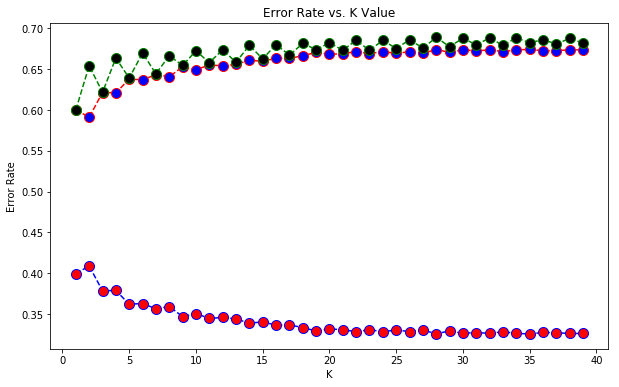

In [40]:
%%time

plt.figure(figsize=(10,6))
plt.plot(np.arange(1, 40, 1),error_rate,color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.plot(np.arange(1, 40, 1),acc_score,color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
plt.plot(np.arange(1, 40, 1),pres_score,color='green', linestyle='dashed', marker='o', markerfacecolor='black', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [41]:
%%time

K=19

knn = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean')
knn.fit(X_downsampled_train,y_downsampled_train)
yhat_downsampled = knn.predict(X_downsampled_test)

acc = accuracy_score(y_downsampled_test, yhat_downsampled)
pres = precision_score(y_downsampled_test, yhat_downsampled)
print('Classification Report')
print(classification_report(y_downsampled_test, yhat_downsampled))
print('Confusion Matrix')
print(confusion_matrix(y_downsampled_test, yhat_downsampled))
print('Accuracy of classifier with %d neighbors is: %.2f'%(K,acc))
print('Precision Score of classifier with %d neighbors is: %.2f'%(K,pres))

Classification Report
             precision    recall  f1-score   support

          0       0.67      0.68      0.67      3978
          1       0.67      0.66      0.67      3977

avg / total       0.67      0.67      0.67      7955

Confusion Matrix
[[2707 1271]
 [1348 2629]]
Accuracy of classifier with 19 neighbors is: 0.67
Precision Score of classifier with 19 neighbors is: 0.67
Wall time: 4.4 s


In [42]:
from sklearn.neighbors.nearest_centroid import NearestCentroid

In [43]:
%%time

for d in ['l1', 'l2', 'cosine', 'euclidean']:
    clf = NearestCentroid(metric=d)
    clf.fit(X_downsampled_train, y_downsampled_train)
    yhat_downsampled = clf.predict(X_downsampled_test)
    acc = accuracy_score(y_downsampled_test, yhat_downsampled)
    pres = precision_score(y_downsampled_test, yhat_downsampled)
    print('Classification Report')
    print(classification_report(y_downsampled_test, yhat_downsampled))
    print('Confusion Matrix')
    print(confusion_matrix(y_downsampled_test, yhat_downsampled))
    print('Accuracy of classifier with %s metric is: %.2f'%(d,acc))
    print('Precision Score of classifier with %s metric is: %.2f'%(d,pres))

Classification Report
             precision    recall  f1-score   support

          0       0.62      0.77      0.69      3978
          1       0.70      0.53      0.61      3977

avg / total       0.66      0.65      0.65      7955

Confusion Matrix
[[3081  897]
 [1858 2119]]
Accuracy of classifier with l1 metric is: 0.65
Precision Score of classifier with l1 metric is: 0.70
Classification Report
             precision    recall  f1-score   support

          0       0.64      0.70      0.67      3978
          1       0.67      0.61      0.64      3977

avg / total       0.66      0.66      0.65      7955

Confusion Matrix
[[2776 1202]
 [1539 2438]]
Accuracy of classifier with l2 metric is: 0.66
Precision Score of classifier with l2 metric is: 0.67
Classification Report
             precision    recall  f1-score   support

          0       0.64      0.70      0.67      3978
          1       0.67      0.61      0.64      3977

avg / total       0.66      0.66      0.65      7955


In [44]:
rfc.fit(X_downsampled_train, y_downsampled_train)

yhat_downsampled = rfc.predict(X_downsampled_test)

acc = accuracy_score(y_downsampled_test, yhat_downsampled)
pres = precision_score(y_downsampled_test, yhat_downsampled)
print('Classification Report')
print(classification_report(y_downsampled_test, yhat_downsampled))
print('Confusion Matrix')
print(confusion_matrix(y_downsampled_test, yhat_downsampled))
print('Accuracy of classifier with %d neighbors is: %.2f'%(K,acc))
print('Precision Score of classifier with %d neighbors is: %.2f'%(K,pres))

Classification Report
             precision    recall  f1-score   support

          0       0.67      0.68      0.68      3978
          1       0.68      0.66      0.67      3977

avg / total       0.67      0.67      0.67      7955

Confusion Matrix
[[2721 1257]
 [1350 2627]]
Accuracy of classifier with 19 neighbors is: 0.67
Precision Score of classifier with 19 neighbors is: 0.68
